# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></div><div class="lev1 toc-item"><a href="#Load-LAU1-and-LAU2-codes" data-toc-modified-id="Load-LAU1-and-LAU2-codes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load LAU1 and LAU2 codes</a></div><div class="lev2 toc-item"><a href="#Create-the-hierarchy-of-the-LAU-codes" data-toc-modified-id="Create-the-hierarchy-of-the-LAU-codes-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Create the hierarchy of the LAU codes</a></div><div class="lev2 toc-item"><a href="#Check-that-the-indexes/code-association-holds-at-each-level..." data-toc-modified-id="Check-that-the-indexes/code-association-holds-at-each-level...-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Check that the indexes/code association holds at each level...</a></div><div class="lev2 toc-item"><a href="#Compute-the-population-for-each-shape-in-the-finest-level" data-toc-modified-id="Compute-the-population-for-each-shape-in-the-finest-level-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Compute the population for each shape in the finest level</a></div><div class="lev2 toc-item"><a href="#Compute-the-baricenter-of-each-LAU2" data-toc-modified-id="Compute-the-baricenter-of-each-LAU2-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Compute the baricenter of each LAU2</a></div><div class="lev2 toc-item"><a href="#Save-the-dataframes-and-mappings" data-toc-modified-id="Save-the-dataframes-and-mappings-25"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Save the dataframes and mappings</a></div>

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Overview

In this notebook we show how to combine the NUTS3 codes and areas with the shapes of the LAU1 and LAU2 codes manually collected by us.

We will end up with a geo-dataframe containing the information about the hierarchical code (NUTS3+LAU1 and 2) of an area, its population and the shape of the area represented by a Shapely object.

This dataframe will then be used by the synthetic population generator to iterate over all the geographical areas that have to be populated.

Though in this example we will focus on **Piedimont** (a region in the north-west of Italy), the procedure can be extended to the whole European countries when data will be collected.


# Load LAU1 and LAU2 codes

Here we manually load the data about LAU1 and LAU2 areas as we did not include them in the geo-db yet. On the other hand, we will fetch the NUT3 areas and code directly from the db.

We will build a hierarchical representation of them to add 2 levels (LAU1 and LAU2) to the 3 levels of NUTS codes.

For each LAU1 we will look for the most overlapping parent among the NUTS3 (the parent) and save the LAU1 code as a son of the NUTS3.

Then we will do the same for each LAU2 code, looking among the LAU1 for the most overlapping shape and marking it as parent.

We then generate the hierarchical codes to append to the NUTS levels for each boundary.

**NOTE**

The `LAU1` and `LAU2` areas have been downloaded using the [overpass-turbo](http://overpass-turbo.eu) website that allows to run straightforward queries to the openstreetmap database.

For example, to get the shapes of LAU1 in Piedimont we just did (through the wizard):

```
type=boundary and admin_level=8 in Piemonte
```

where level 8 corresponds to LAU1 areas (italian municipalities). One can do the same to get LAU2 areas (districts of largest cities like Turin) simply asking for level 10.

The results can be exported to geojson and imoprted as geopandas dataframes.

The whole procedure can be automathized by means of the overpass turbo API but we leave this for future work.

Here we just have to set the selected NUTS3 codes we want to work with, i.e. `ITC1` for Piedimont.

In [2]:
selectedNUTS = set(["UK"])
countryCode = "UK"

NUTSlevel = 3
selectedNUTSlevel = 0

LAU1_geoJsonFileName = "resources/geoJsons/Italia/dec_lvl08.json"
LAU2_geoJsonFileName = "resources/geoJsons/United-Kingdom/Wards_December_2016_Full_Clipped_Boundaries_in_the_UK.geojson"

In [3]:
import shapely
import geopandas as gpd

In [4]:
import synpopUtils

In [5]:
reload(synpopUtils)

<module 'synpopUtils' from 'synpopUtils.pyc'>

In [6]:
import geoMongoUtils

In [7]:
reload(geoMongoUtils)

<module 'geoMongoUtils' from 'geoMongoUtils.pyc'>

In [8]:
myClient = geoMongoUtils.geoMongoClient(dbURL="localhost", dbUser="ubi15", dbPort=27017, cellColl="europeCells")

Enter password for mongo:········


In [9]:
myClient.getCountryLevelCodes(countryCode=countryCode)

Counter({u'UKC': 1,
         u'UKD': 1,
         u'UKE': 1,
         u'UKF': 1,
         u'UKG': 1,
         u'UKH': 1,
         u'UKI': 1,
         u'UKJ': 1,
         u'UKK': 1,
         u'UKL': 1,
         u'UKM': 1,
         u'UKN': 1})

In [10]:
# Load the nuts3 boundaries from the db
nuts3 = myClient.getCountryLevel(countryCode=countryCode, level=NUTSlevel)
nuts3country_gdf = gpd.GeoDataFrame.from_features(nuts3)

nuts3_gdf = nuts3country_gdf[nuts3country_gdf.NUTS_ID.str[:selectedNUTSlevel+2].isin(selectedNUTS)].copy(deep=True)
nuts3_gdf = nuts3_gdf[["NUTS_ID", "NUTS_NAME", "STAT_LEVL_", "geometry"]]
nuts3_gdf.columns = ["id", "name", "admin_level", "geometry"]

In [17]:
if countryCode == "UK":
    lau1 = myClient.getCountryLevel(countryCode=countryCode, level=4)
    lau1_gpd = gpd.GeoDataFrame.from_features(lau1)
    lau1_gpd = lau1_gpd[lau1_gpd.NUTS_ID.str[:selectedNUTSlevel+2].isin(selectedNUTS)].copy(deep=True)
    lau1_gpd = lau1_gpd[["NUTS_ID", "NUTS_NAME", "STAT_LEVL_", "geometry"]]
    lau1_gpd.columns = ["id", "name", "admin_level", "geometry"]
    del lau1
    
    lau2_gpd = gpd.read_file(LAU2_geoJsonFileName)
    lau2_gpd = lau2_gpd[lau2_gpd.type != "Point"]
    lau2_gpd = lau2_gpd[["lad16cd", "lad16nm", "wd16cd", "geometry"]]
    lau2_gpd.columns = ["id", "name", "admin_level", "geometry"]
else:
    # Load manually the LAU1 and LAU2 for testing...
    # Remove the capital towns...
    # Remove useless/rename columns
    # lau1_gpd = lau1_gpd[["DEBKG_ID", "GEN", "GF", "geometry"]] # form germany shapefile
    lau1_gpd = gpd.read_file(LAU1_geoJsonFileName)
    lau1_gpd = lau1_gpd[lau1_gpd.type != "Point"]
    lau1_gpd = lau1_gpd[["id", "name", "admin_level", "geometry"]]
    
    lau2_gpd = gpd.read_file(LAU2_geoJsonFileName)
    lau2_gpd = lau2_gpd[lau2_gpd.type != "Point"]
    lau2_gpd = lau2_gpd[["id", "name", "admin_level", "geometry"]]
    lau2_gpd["admin_level"] = 10
    
lau1_gpd["admin_level"] = 8
lau2_gpd["admin_level"] = 10
lau1_gpd.columns = lau2_gpd.columns

nuts3_gdf.reset_index(drop=True, inplace=True)
lau1_gpd.reset_index(drop=True, inplace=True)
lau2_gpd.reset_index(drop=True, inplace=True)

In [18]:
nuts3_gdf.head()

,id,name,admin_level,geometry
0,UKC11,Hartlepool and Stockton-on-Tees,3,POLYGON ((-1.242229500000008 54.72259500000001...
1,UKC12,South Teesside,3,POLYGON ((-0.9843485000000101 54.5893669999999...
2,UKC13,Darlington,3,POLYGON ((-1.606587288000014 54.61722049399998...
3,UKC14,Durham CC,3,POLYGON ((-1.734096000000022 54.91823599899999...
4,UKC21,Northumberland,3,(POLYGON ((-2.000007499999981 55.7858620000000...


In [19]:
lau1_gpd.head()

,id,name,admin_level,geometry
0,UKC11A,Hartlepool,8,POLYGON ((-1.268455564605338 54.72611630976578...
1,UKC11B,Stockton-on-Tees,8,POLYGON ((-1.317285878674298 54.64480329335184...
2,UKC12A,Middlesbrough,8,POLYGON ((-1.251121773427193 54.59152982347162...
3,UKC12B,Redcar and Cleveland,8,POLYGON ((-1.136331574617273 54.64503531700071...
4,UKC13A,Darlington,8,POLYGON ((-1.637677671242585 54.61713780181557...


In [20]:
lau2_gpd.head()

,id,name,admin_level,geometry
0,E09000002,Barking and Dagenham,10,(POLYGON ((0.0809460269467943 51.5443786291860...
1,E09000002,Barking and Dagenham,10,POLYGON ((0.1563782515338294 51.55102026983288...
2,E09000002,Barking and Dagenham,10,POLYGON ((0.1271555183335555 51.55560636295905...
3,E09000002,Barking and Dagenham,10,POLYGON ((0.1482069466409845 51.59896215460819...
4,E09000002,Barking and Dagenham,10,POLYGON ((0.1851486121556226 51.56478877312095...


In [21]:
# Fix all the invalid boundaries.
# Invalid boundaries are the ones with lines auto-intersecting.
# We can easily fix them by calling the `shape.buffer(0)` method.

for dfid, tmp_gdf in enumerate([nuts3_gdf, lau1_gpd, lau2_gpd]):
    for invalid_index in tmp_gdf[ ~(tmp_gdf.geometry.is_valid)].index:
        before = tmp_gdf.loc[invalid_index, "geometry"]
        print "fixing code %d at level %d" % (invalid_index, dfid)
        fix = before.buffer(0)
        tmp_gdf.at[invalid_index, "geometry"] = fix
    print "Level %d done: " % dfid, sum(tmp_gdf.geometry.is_valid), "/", tmp_gdf.shape

Level 0 done:  173 / (173, 4)
Level 1 done:  380 / (380, 4)
fixing code 2693 at level 2
fixing code 7952 at level 2
Level 2 done:  9130 / (9130, 4)


## Create the hierarchy of the LAU codes

Here we want to create the most refined representation possible of the geo area.

To do this we aggregate the NUTS3 boundaries with the manually imported LAU1 and LAU2.

If for a given LAU1 we do not have children, we simply project the LAU1 to the lower level and use it as the only LAU2 code of the area.

We will end up with a list

`[geo-dataframe0, geo-dataframe1, ..., geo-dataframeL-1]`

where `geodataframeI` is the dataframe containing the information on the areas at a given `I` level of the hierarchy.

Also, `geodataframe` will have a `code` column containing the `(l0, l1, ..., lI)` tuple representing the hierarchical code of the shape plus `I+1` columns called `l0`, `l1`, ..., `lI` containing the single level values.

In [22]:
import copy

In [23]:
NUTS_LAU_hierarchy = copy.deepcopy([nuts3_gdf, lau1_gpd, lau2_gpd])

In [24]:
# Pre-project missing sons...
#NUTS_LAU_hierarchy = copy.deepcopy([nuts3_gdf, lau1_gpd, lau2_gpd])
#NUTS_LAU_hierarchy, overlapCounter = synpopUtils.preProjectToFinestLevel(NUTS_LAU_hierarchy=NUTS_LAU_hierarchy)

In [25]:
# fig, ax = plt.subplots(1, len(overlapCounter), figsize=(4*len(overlapCounter), 4))
# for iii, vals in enumerate(overlapCounter):
#     tmp_ax = ax[iii]
#     tmp_ax.hist(vals)

In [26]:
reload(synpopUtils)

<module 'synpopUtils' from 'synpopUtils.pyc'>

In [27]:
# Assign hierarchy codes...
synpopUtils.assignHierarchyCodes(NUTS_LAU_hierarchy)

Doing level 0
Doing level 1

Child 13 name Barrow-in-Furness id UKD11B at level 1 had a parent overlap of 0.583, deleting it...

Child 50 name Wirral id UKD74A at level 1 had a parent overlap of 0.612, deleting it...

Child 175 name Southend-on-Sea id UKH31A at level 1 had a parent overlap of 0.602, deleting it...

Child 188 name Rochford id UKH37C at level 1 had a parent overlap of 0.651, deleting it...

Child 262 name Portsmouth id UKJ31A at level 1 had a parent overlap of 0.674, deleting it...

Child 268 name Havant id UKJ35D at level 1 had a parent overlap of 0.692, deleting it...

Child 289 name Bristol, City of id UKK11A at level 1 had a parent overlap of 0.465, deleting it...

Child 317 name Torbay id UKK42A at level 1 had a parent overlap of 0.516, deleting it...

Child 365 name North Ayrshire id UKM33B at level 1 had a parent overlap of 0.492, deleting it...

Child 375 name Highland id UKM61A at level 1 had a parent overlap of 0.499, deleting it...
Doing level 2

Missing paren


Missing parent for child 2904 name Havant id E07000090 at level 2, deleting it...

Child 2905 name Havant id E07000090 at level 2 had a parent overlap of 0.000, deleting it...

Missing parent for child 2906 name Havant id E07000090 at level 2, deleting it...

Child 2907 name Havant id E07000090 at level 2 had a parent overlap of 0.000, deleting it...

Child 2908 name Havant id E07000090 at level 2 had a parent overlap of 0.000, deleting it...

Child 2909 name Havant id E07000090 at level 2 had a parent overlap of 0.000, deleting it...

Child 2910 name Havant id E07000090 at level 2 had a parent overlap of 0.000, deleting it...

Missing parent for child 2911 name Havant id E07000090 at level 2, deleting it...

Missing parent for child 2912 name Havant id E07000090 at level 2, deleting it...

Child 2913 name Havant id E07000090 at level 2 had a parent overlap of 0.000, deleting it...

Child 2914 name Havant id E07000090 at level 2 had a parent overlap of 0.000, deleting it...

Child 291


Missing parent for child 7488 name Antrim and Newtownabbey id N09000001 at level 2, deleting it...

Missing parent for child 7489 name Antrim and Newtownabbey id N09000001 at level 2, deleting it...

Missing parent for child 7490 name Antrim and Newtownabbey id N09000001 at level 2, deleting it...

Missing parent for child 7491 name Antrim and Newtownabbey id N09000001 at level 2, deleting it...

Missing parent for child 7492 name Antrim and Newtownabbey id N09000001 at level 2, deleting it...

Missing parent for child 7493 name Antrim and Newtownabbey id N09000001 at level 2, deleting it...

Missing parent for child 7494 name Antrim and Newtownabbey id N09000001 at level 2, deleting it...

Missing parent for child 7495 name Antrim and Newtownabbey id N09000001 at level 2, deleting it...

Missing parent for child 7496 name Antrim and Newtownabbey id N09000001 at level 2, deleting it...

Missing parent for child 7497 name Antrim and Newtownabbey id N09000001 at level 2, deleting it...



Missing parent for child 7569 name Belfast id N09000003 at level 2, deleting it...

Missing parent for child 7570 name Belfast id N09000003 at level 2, deleting it...

Missing parent for child 7571 name Belfast id N09000003 at level 2, deleting it...

Missing parent for child 7572 name Belfast id N09000003 at level 2, deleting it...

Missing parent for child 7573 name Belfast id N09000003 at level 2, deleting it...

Missing parent for child 7574 name Belfast id N09000003 at level 2, deleting it...

Missing parent for child 7575 name Belfast id N09000003 at level 2, deleting it...

Missing parent for child 7576 name Belfast id N09000003 at level 2, deleting it...

Missing parent for child 7577 name Belfast id N09000003 at level 2, deleting it...

Missing parent for child 7578 name Belfast id N09000003 at level 2, deleting it...

Missing parent for child 7579 name Belfast id N09000003 at level 2, deleting it...

Missing parent for child 7580 name Belfast id N09000003 at level 2, deletin


Missing parent for child 7657 name Derry City and Strabane id N09000005 at level 2, deleting it...

Missing parent for child 7658 name Derry City and Strabane id N09000005 at level 2, deleting it...

Missing parent for child 7659 name Derry City and Strabane id N09000005 at level 2, deleting it...

Missing parent for child 7660 name Derry City and Strabane id N09000005 at level 2, deleting it...

Missing parent for child 7661 name Derry City and Strabane id N09000005 at level 2, deleting it...

Missing parent for child 7662 name Derry City and Strabane id N09000005 at level 2, deleting it...

Missing parent for child 7663 name Derry City and Strabane id N09000005 at level 2, deleting it...

Missing parent for child 7664 name Derry City and Strabane id N09000005 at level 2, deleting it...

Missing parent for child 7665 name Derry City and Strabane id N09000005 at level 2, deleting it...

Missing parent for child 7666 name Derry City and Strabane id N09000005 at level 2, deleting it...



Missing parent for child 7741 name Lisburn and Castlereagh id N09000007 at level 2, deleting it...

Missing parent for child 7742 name Lisburn and Castlereagh id N09000007 at level 2, deleting it...

Missing parent for child 7743 name Lisburn and Castlereagh id N09000007 at level 2, deleting it...

Missing parent for child 7744 name Lisburn and Castlereagh id N09000007 at level 2, deleting it...

Missing parent for child 7745 name Lisburn and Castlereagh id N09000007 at level 2, deleting it...

Missing parent for child 7746 name Lisburn and Castlereagh id N09000007 at level 2, deleting it...

Missing parent for child 7747 name Lisburn and Castlereagh id N09000007 at level 2, deleting it...

Missing parent for child 7748 name Lisburn and Castlereagh id N09000007 at level 2, deleting it...

Missing parent for child 7749 name Lisburn and Castlereagh id N09000007 at level 2, deleting it...

Missing parent for child 7750 name Lisburn and Castlereagh id N09000007 at level 2, deleting it...



Missing parent for child 7828 name Mid Ulster id N09000009 at level 2, deleting it...

Missing parent for child 7829 name Mid Ulster id N09000009 at level 2, deleting it...

Missing parent for child 7830 name Mid Ulster id N09000009 at level 2, deleting it...

Missing parent for child 7831 name Mid Ulster id N09000009 at level 2, deleting it...

Missing parent for child 7832 name Mid Ulster id N09000009 at level 2, deleting it...

Missing parent for child 7833 name Mid Ulster id N09000009 at level 2, deleting it...

Missing parent for child 7834 name Mid Ulster id N09000009 at level 2, deleting it...

Missing parent for child 7835 name Mid Ulster id N09000009 at level 2, deleting it...

Missing parent for child 7836 name Mid Ulster id N09000009 at level 2, deleting it...

Missing parent for child 7837 name Mid Ulster id N09000009 at level 2, deleting it...

Missing parent for child 7838 name Mid Ulster id N09000009 at level 2, deleting it...

Missing parent for child 7839 name Mid Uls


Missing parent for child 7914 name Ards and North Down id N09000011 at level 2, deleting it...

Missing parent for child 7915 name Ards and North Down id N09000011 at level 2, deleting it...

Missing parent for child 7916 name Ards and North Down id N09000011 at level 2, deleting it...

Missing parent for child 7917 name Ards and North Down id N09000011 at level 2, deleting it...

Missing parent for child 7918 name Ards and North Down id N09000011 at level 2, deleting it...

Missing parent for child 7919 name Ards and North Down id N09000011 at level 2, deleting it...

Missing parent for child 7920 name Ards and North Down id N09000011 at level 2, deleting it...

Missing parent for child 7921 name Ards and North Down id N09000011 at level 2, deleting it...

Missing parent for child 7922 name Ards and North Down id N09000011 at level 2, deleting it...

Missing parent for child 7923 name Ards and North Down id N09000011 at level 2, deleting it...

Missing parent for child 7924 name Ards

In [28]:
NUTS_LAU_hierarchy[-1].head()

,id,name,admin_level,geometry,code,l0,l1,l2
0,E09000002,Barking and Dagenham,10,(POLYGON ((0.0809460269467943 51.5443786291860...,"(89, 205, 0)",89,205,0
1,E09000002,Barking and Dagenham,10,POLYGON ((0.1563782515338294 51.55102026983288...,"(89, 205, 1)",89,205,1
2,E09000002,Barking and Dagenham,10,POLYGON ((0.1271555183335555 51.55560636295905...,"(89, 205, 2)",89,205,2
3,E09000002,Barking and Dagenham,10,POLYGON ((0.1482069466409845 51.59896215460819...,"(89, 205, 3)",89,205,3
4,E09000002,Barking and Dagenham,10,POLYGON ((0.1851486121556226 51.56478877312095...,"(89, 205, 4)",89,205,4


In [29]:
NUTS_LAU_hierarchy_BACKUP = copy.deepcopy(NUTS_LAU_hierarchy)

In [30]:
# Check that we populated correctly the codes...
for l, d in enumerate(NUTS_LAU_hierarchy):
    print l, d.count(), d.shape, len(d["code"].unique())

0 id             173
name           173
admin_level    173
geometry       173
code           173
l0             173
dtype: int64 (173, 6) 173
1 id             370
name           370
admin_level    370
geometry       370
code           370
l0             370
l1             370
dtype: int64 (370, 7) 370
2 id             8496
name           8496
admin_level    8496
geometry       8496
code           8496
l0             8496
l1             8496
l2             8496
dtype: int64 (8496, 8) 8496


Correct: 1307    (1, 3, 1307)
1308    (1, 3, 1308)
1309    (1, 3, 1309)
1310    (1, 3, 1310)
1311    (1, 3, 1311)
1312    (1, 3, 1312)
1313    (1, 3, 1313)
1314    (1, 3, 1314)
1315    (1, 3, 1315)
1316    (1, 3, 1316)
1317    (1, 3, 1317)
1318    (1, 3, 1318)
1319    (1, 3, 1319)
1320    (1, 3, 1320)
1321    (1, 3, 1321)
1322    (1, 3, 1322)
1323    (1, 3, 1323)
1324    (1, 3, 1324)
1325    (1, 3, 1325)
1326    (1, 3, 1326)
1327    (1, 3, 1327)
1328    (1, 3, 1328)
6226    (1, 2, 6226)
6227    (1, 2, 6227)
6228    (1, 2, 6228)
6229    (1, 2, 6229)
6230    (1, 2, 6230)
6231    (1, 2, 6231)
6232    (1, 2, 6232)
6233    (1, 2, 6233)
6234    (1, 2, 6234)
6235    (1, 2, 6235)
6236    (1, 2, 6236)
6237    (1, 2, 6237)
6238    (1, 2, 6238)
6239    (1, 2, 6239)
6240    (1, 2, 6240)
6241    (1, 2, 6241)
6242    (1, 2, 6242)
6243    (1, 2, 6243)
6244    (1, 2, 6244)
6245    (1, 2, 6245)
Name: code, dtype: object


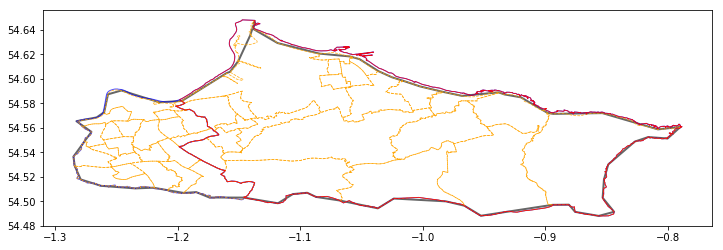

In [31]:
fig, ax = plt.subplots(figsize=(12,12))
synpopUtils.plotHierarchyParent(NUTS_LAU_hierarchy, parentCode=(1,), ax=ax)

In [32]:
NUTS_LAU_hierarchy = copy.deepcopy(NUTS_LAU_hierarchy_BACKUP)
NUTS_LAU_hierarchy, overlapCounter = synpopUtils.projectToFinestLevel(NUTS_LAU_hierarchy=NUTS_LAU_hierarchy)

Doing level 0
Parent 172 name West and South of Northern Ireland id UKN05 at level 0 was covered by 0.00 percent by sons, adding children...                                                                  
Done!
Doing level 1
Parent 379 name Shetland Islands id UKM66A at level 1 was covered by 0.89 percent by sons, adding children...                                                                                                                 
Done!


In [33]:
# fix polygons:
for level, gdf in enumerate(NUTS_LAU_hierarchy):
    for index, row in gdf.iterrows():
        if not row["geometry"].is_valid:
            gdf.at[index, "geometry"] = row["geometry"].buffer(0)
    print "level %d done..." % level

level 0 done...
level 1 done...
level 2 done...


In [34]:
# Manual fixes for problematic polygons...
if countryCode == "DE":
    index = 6939
    coords = np.asarray(NUTS_LAU_hierarchy[-1].loc[index].geometry.exterior.coords)
    coords[26][1] = 53.4843
    NUTS_LAU_hierarchy[-1].at[index, "geometry"]= shapely.geometry.Polygon(coords)

Correct: 1307    (0, 1, 1329)
1308    (0, 1, 1330)
1309    (0, 1, 1331)
1310    (0, 1, 1332)
1311    (0, 1, 1333)
1312    (0, 1, 1334)
1313    (0, 1, 1335)
1314    (0, 1, 1336)
1315    (0, 1, 1337)
1316    (0, 1, 1338)
1317    (0, 1, 1339)
1318    (0, 1, 1340)
1319    (0, 1, 1341)
1320    (0, 1, 1342)
1321    (0, 1, 1343)
1322    (0, 1, 1344)
1323    (0, 1, 1345)
1324    (0, 1, 1346)
1325    (0, 1, 1347)
1326    (0, 1, 1348)
1327    (0, 1, 1349)
1328    (0, 1, 1350)
1329    (0, 1, 1351)
1330    (0, 1, 1352)
1331    (0, 1, 1353)
1332    (0, 1, 1354)
5238    (0, 0, 5333)
5239    (0, 0, 5334)
5240    (0, 0, 5335)
5241    (0, 0, 5336)
5242    (0, 0, 5337)
5243    (0, 0, 5338)
5244    (0, 0, 5339)
5245    (0, 0, 5340)
5246    (0, 0, 5341)
5247    (0, 0, 5342)
5248    (0, 0, 5343)
8496    (0, 0, 9130)
Name: code, dtype: object


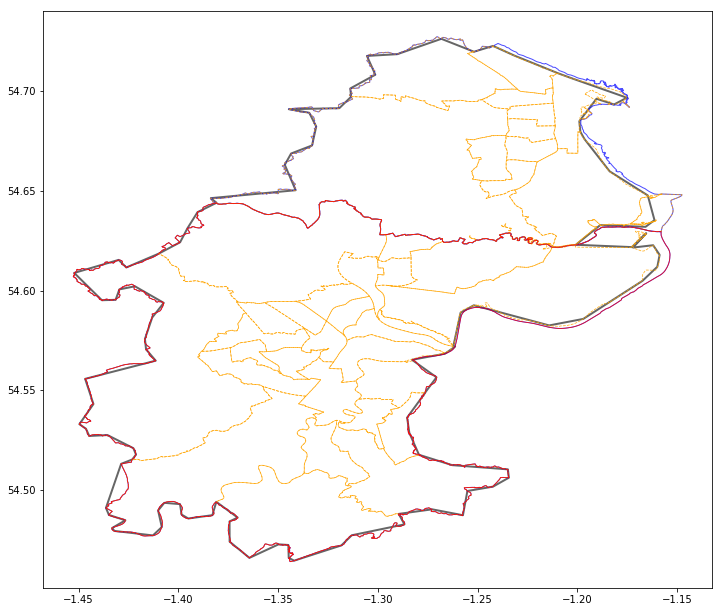

In [35]:
# Check if we did it...
fig, ax = plt.subplots(figsize=(12,12))
synpopUtils.plotHierarchyParent(NUTS_LAU_hierarchy, parentCode=(0,), ax=ax)

In [36]:
%%time
if False:
    # Check for a given NUT3 how much it is covered by the sons...
    singleNUTS3 = list(selectedNUTS)[0]

    aggregated_shape = NUTS_LAU_hierarchy[-1].unary_union

    # Check the NUTS2 coverage
    aggregated_shape = NUTS_LAU_hierarchy[-1]["geometry"].iloc[0]
    i = 1
    for shape in NUTS_LAU_hierarchy[-1]["geometry"].iloc[1:]:
        aggregated_shape = aggregated_shape.union(shape)
        i += 1
        sys.stdout.write("\r%05d / %05d" % (i, NUTS_LAU_hierarchy[-1].shape[0]))
        sys.stdout.flush()
    sys.stdout.write("\nDone!\n")
    sys.stdout.flush()

    # Fetch the NUTS2
    reference_shape = shapely.geometry.shape(myClient.getBoundaryByID(singleNUTS3)["geometry"])

    print reference_shape.intersection(aggregated_shape).area/reference_shape.area

    reference_shape.difference(aggregated_shape)

    reference_shape.symmetric_difference(aggregated_shape)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 21 µs


In [37]:
import fiona
print fiona.supported_drivers

{'ESRI Shapefile': 'raw', 'OpenFileGDB': 'r', 'SUA': 'r', 'ARCGEN': 'r', 'GeoJSON': 'rw', 'Idrisi': 'r', 'GPX': 'raw', 'SEGY': 'r', 'BNA': 'raw', 'AeronavFAA': 'r', 'GPSTrackMaker': 'raw', 'DGN': 'raw', 'PCIDSK': 'r', 'MapInfo File': 'raw', 'DXF': 'raw'}


In [38]:
for level, gdf in enumerate(NUTS_LAU_hierarchy):
    gdf[[c for c in gdf.columns if c != "code"]].to_file(
        filename="resources/geoJsons/Exported_%s_lvl%02d.shp"
            % ("-".join([c for c in selectedNUTS]), level))

## Check that the indexes/code association holds at each level...

And also save the `{NUTS: index}` and `{index: NUTS}` mappings to be saved (as `pandas.Series` objects).

In [39]:
for level, levelData in enumerate(NUTS_LAU_hierarchy):
    if level == 0:
        codeValid = sum(levelData.index == levelData["code"].apply(lambda v: v[level]))
        columnValid = sum(levelData.index == levelData["l%d"%level])
        codeValues = len(levelData["l%d"%level].unique())
        levelDim = levelData.shape[0]

        assert codeValid == columnValid == codeValues == levelDim
        print levelDim, codeValid, columnValid, codeValues
    else:
        codeValid = len(levelData["code"].unique())
        levelDim = levelData.shape[0]
        assert codeValid == levelDim
        print levelDim, codeValid

173 173 173 173
394 394
8597 8597


In [40]:
NUTS2index = pd.Series({r["id"]: i for i, r in NUTS_LAU_hierarchy[0].iterrows()})
index2NUTS = pd.Series({v: k for k, v in NUTS2index.iteritems()})

## Compute the population for each shape in the finest level

In [41]:
#reload(geoMongoUtils)

In [42]:
#myClient = geoMongoUtils.geoMongoClient(dbURL="localhost", dbUser="ubi15", dbPort=27017, cellColl="europeCells")

In [43]:
import geojson

In [44]:
reference_gdf = NUTS_LAU_hierarchy[-1]

# Create the columns of the geodf where we save the population density array and the
# intersection boundary of the cells intersecating with each boundary 
reference_gdf["CELLS_CDF"] = [[] for i in range(reference_gdf.shape[0])]
reference_gdf["CELLS_CDF"] = reference_gdf["CELLS_CDF"].astype(object)
reference_gdf["CELLS_SHP"] = [[] for i in range(reference_gdf.shape[0])]
reference_gdf["CELLS_SHP"] = reference_gdf["CELLS_SHP"].astype(object)
reference_gdf["POP"] = .0

# Since we have a lot of municipalities under the same
# NUTS3 we save the last seen NUTS level from which we
# computed the household stats to save time
lastStatisticNUTS = None

tot_pop = 0
counter, total = 1,  reference_gdf.shape[0]
for LAU2_index, LAU2_data in reference_gdf.iterrows():
    tmp_code = LAU2_data["code"]
    tmp_nuts3_id = tmp_code[0]
    tmp_nuts3_code = index2NUTS[tmp_nuts3_id]
    
    # Retrieving the boundary to compute the cells inside of this boundary...
    tmp_boundSHP = LAU2_data["geometry"]
    tmp_boundGJS = geojson.Feature(geometry=tmp_boundSHP, features={})
    
    tmp_pop_count = .0
    cellsPDF, cellsIntersectionSHP = [], []
    for cell, frac in myClient.overlapCell(tmp_boundGJS):
        # I evaluate the fraction of people living in each cell and 
        # for each cell I save in one array the fraction of this cell over the total population in the 
        # nuts and in another the interspection shape.
        if frac < .01: continue    
        tmp_pop = frac*cell["properties"]["pop2015"]
        if tmp_pop < 1: continue
        tmp_pop_count += tmp_pop
        
        cellSHP = synpopUtils.cell2shape(cell)
        intersectionSHP = synpopUtils.shapeCell2intersection(tmp_boundSHP, cellSHP)
        tmp_bounds = intersectionSHP.bounds
        min_x, min_y = tmp_bounds[0], tmp_bounds[1]
        dx = tmp_bounds[2] - tmp_bounds[0]
        dy = tmp_bounds[3] - tmp_bounds[1]
        
        cellsPDF.append(tmp_pop)
        cellsIntersectionSHP.append((intersectionSHP, min_x, min_y, dx, dy))
    
    if len(cellsPDF) < 1:
        print "\nNo cells found within code %s name %s" % (tmp_code, LAU2_data["name"])
        continue
    
    # Now we compute the probability for an household to be created in a cell...
    cellsPDF = np.array(cellsPDF)
    cellsCDF = cellsPDF.cumsum()
    cellsCDF /= cellsCDF[-1]
    
    # Save cells CDF, overlap shapes and population in the gdf...
    reference_gdf.at[LAU2_index, "CELLS_CDF"] = cellsCDF
    reference_gdf.at[LAU2_index, "CELLS_SHP"] = cellsIntersectionSHP
    reference_gdf.at[LAU2_index, "POP"] = tmp_pop_count
    
    tot_pop += tmp_pop_count
    
    sys.stdout.write("\r%04d / %04d: stat NUTS %r - Code %r - Name %r                                           "
                     % (counter, total, tmp_nuts3_code,  tmp_code, LAU2_data["name"]))
    sys.stdout.flush()
    counter += 1
    
print "\nTOT", tot_pop
print "\nDone!"

8597 / 8597: stat NUTS u'UKM66' - Code (167, 379, 8596) - Name u'Shetland Islands'                                                       
TOT 60508521.6084

Done!


In [45]:
reference_gdf.head(3)

,id,name,admin_level,geometry,code,l0,l1,l2,CELLS_CDF,CELLS_SHP,POP
0,E09000002,Barking and Dagenham,10,(POLYGON ((0.0809460269467943 51.5443786291860...,"(89, 205, 0)",89,205,0,"[0.20909218345027092, 0.21664055819028463, 0.5...",[((POLYGON ((0.08333333333456494 51.5416666666...,12817.215797
1,E09000002,Barking and Dagenham,10,POLYGON ((0.1563782515338294 51.55102026983288...,"(89, 205, 1)",89,205,1,"[0.04911037879048084, 0.09469278761521, 0.4657...",[(POLYGON ((0.1500000000012355 51.551323859830...,11285.027580
2,E09000002,Barking and Dagenham,10,POLYGON ((0.1271555183335555 51.55560636295905...,"(89, 205, 2)",89,205,2,"[0.016553286180208925, 0.1688689187724089, 0.3...",[(POLYGON ((0.1083333333345783 51.552235926969...,10236.785755


## Compute the baricenter of each LAU2

In [46]:
from haversine import haversine
from scipy.spatial.distance import pdist, cdist, squareform

In [47]:
baricenter = np.empty((reference_gdf.shape[0], 2))
for i, d in reference_gdf.iterrows():
    if d["CELLS_SHP"]:
        xys = np.array([[coll[0].centroid.x, coll[0].centroid.y] for coll in d["CELLS_SHP"]])
        cdf = d["CELLS_CDF"]
        pdf = np.array([cdf[0]] + list(np.diff(cdf)))
        baricenter[i] = np.sum(xys*pdf[:,None], axis=0)/pdf.sum(axis=0)
    else:
        baricenter[i] = np.array([d["geometry"].centroid.x, d["geometry"].centroid.y])
        
reference_gdf["BARICENTER_X"] = baricenter[:,0]
reference_gdf["BARICENTER_Y"] = baricenter[:,1]

In [48]:
reference_gdf.head(3)

,id,name,admin_level,geometry,code,l0,l1,l2,CELLS_CDF,CELLS_SHP,POP,BARICENTER_X,BARICENTER_Y
0,E09000002,Barking and Dagenham,10,(POLYGON ((0.0809460269467943 51.5443786291860...,"(89, 205, 0)",89,205,0,"[0.20909218345027092, 0.21664055819028463, 0.5...",[((POLYGON ((0.08333333333456494 51.5416666666...,12817.215797,0.078852,51.539906
1,E09000002,Barking and Dagenham,10,POLYGON ((0.1563782515338294 51.55102026983288...,"(89, 205, 1)",89,205,1,"[0.04911037879048084, 0.09469278761521, 0.4657...",[(POLYGON ((0.1500000000012355 51.551323859830...,11285.027580,0.148887,51.545739
2,E09000002,Barking and Dagenham,10,POLYGON ((0.1271555183335555 51.55560636295905...,"(89, 205, 2)",89,205,2,"[0.016553286180208925, 0.1688689187724089, 0.3...",[(POLYGON ((0.1083333333345783 51.552235926969...,10236.785755,0.119716,51.554616


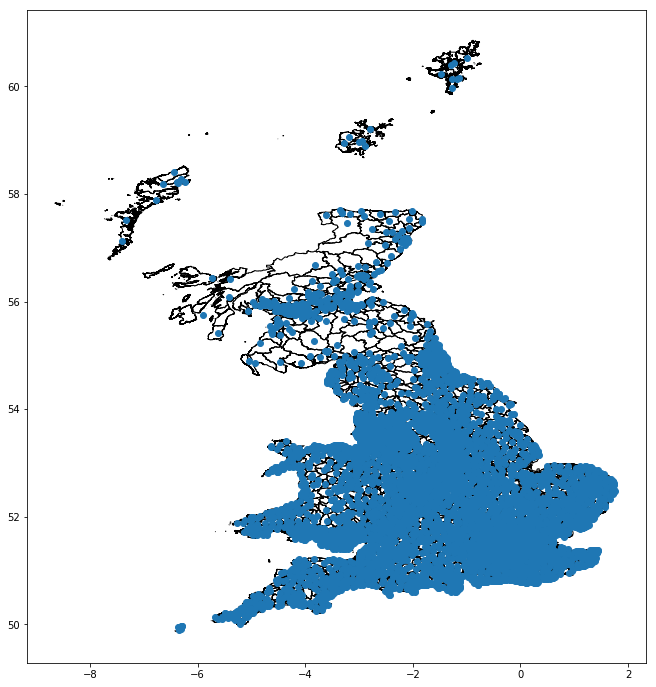

In [49]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
ax.set_aspect("equal")
reference_gdf.plot(ax=ax, color="none", edgecolor="black")
plt.scatter(reference_gdf["BARICENTER_X"], reference_gdf["BARICENTER_Y"])

## Save the dataframes and mappings

In [50]:
import pickle
import gzip

In [51]:
%%time
with gzip.open("resources/United-Kingdom/boundaries/UK_NUTS3_to_LAU2_gdf.pkl.gz", "wb") as fOut:
    pickle.dump(NUTS_LAU_hierarchy, fOut)

CPU times: user 11min 20s, sys: 1.68 s, total: 11min 21s
Wall time: 11min 23s


In [52]:
%%time
index2NUTS.to_pickle("resources/United-Kingdom/boundaries/UK_NUTS3_to_LAU2_id2NUTS.pkl")
NUTS2index.to_pickle("resources/United-Kingdom/boundaries/UK_NUTS3_to_LAU2_NUTS2id.pkl")

CPU times: user 132 ms, sys: 12 ms, total: 144 ms
Wall time: 333 ms
